<a href="https://colab.research.google.com/github/bahar2025-AI/Advanced-Banking-Data-Analysis/blob/main/Banking_Data_Preprocessing_and_Customer_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Customers Dataset Shape: (5000, 14)
Transactions Dataset Shape: (100000, 7)

Customers Dataset Sample:
Transactions Dataset Sample:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   gender              5000 non-null   object 
 3   marital_status      5000 non-null   object 
 4   city                5000 non-null   object 
 5   account_age_months  5000 non-null   int64  
 6   credit_score        4750 non-null   float64
 7   income              4850 non-null   float64
 8   account_balance     5000 non-null   int64  
 9   has_credit_card     5000 non-null   int64  
 10  has_loan            5000 non-null   int64  
 11  has_mortgage        5000 non-null   int64  
 12  has_investment      5000 non-null   int64  
 13  is_active           5

<Figure size 1200x600 with 0 Axes>

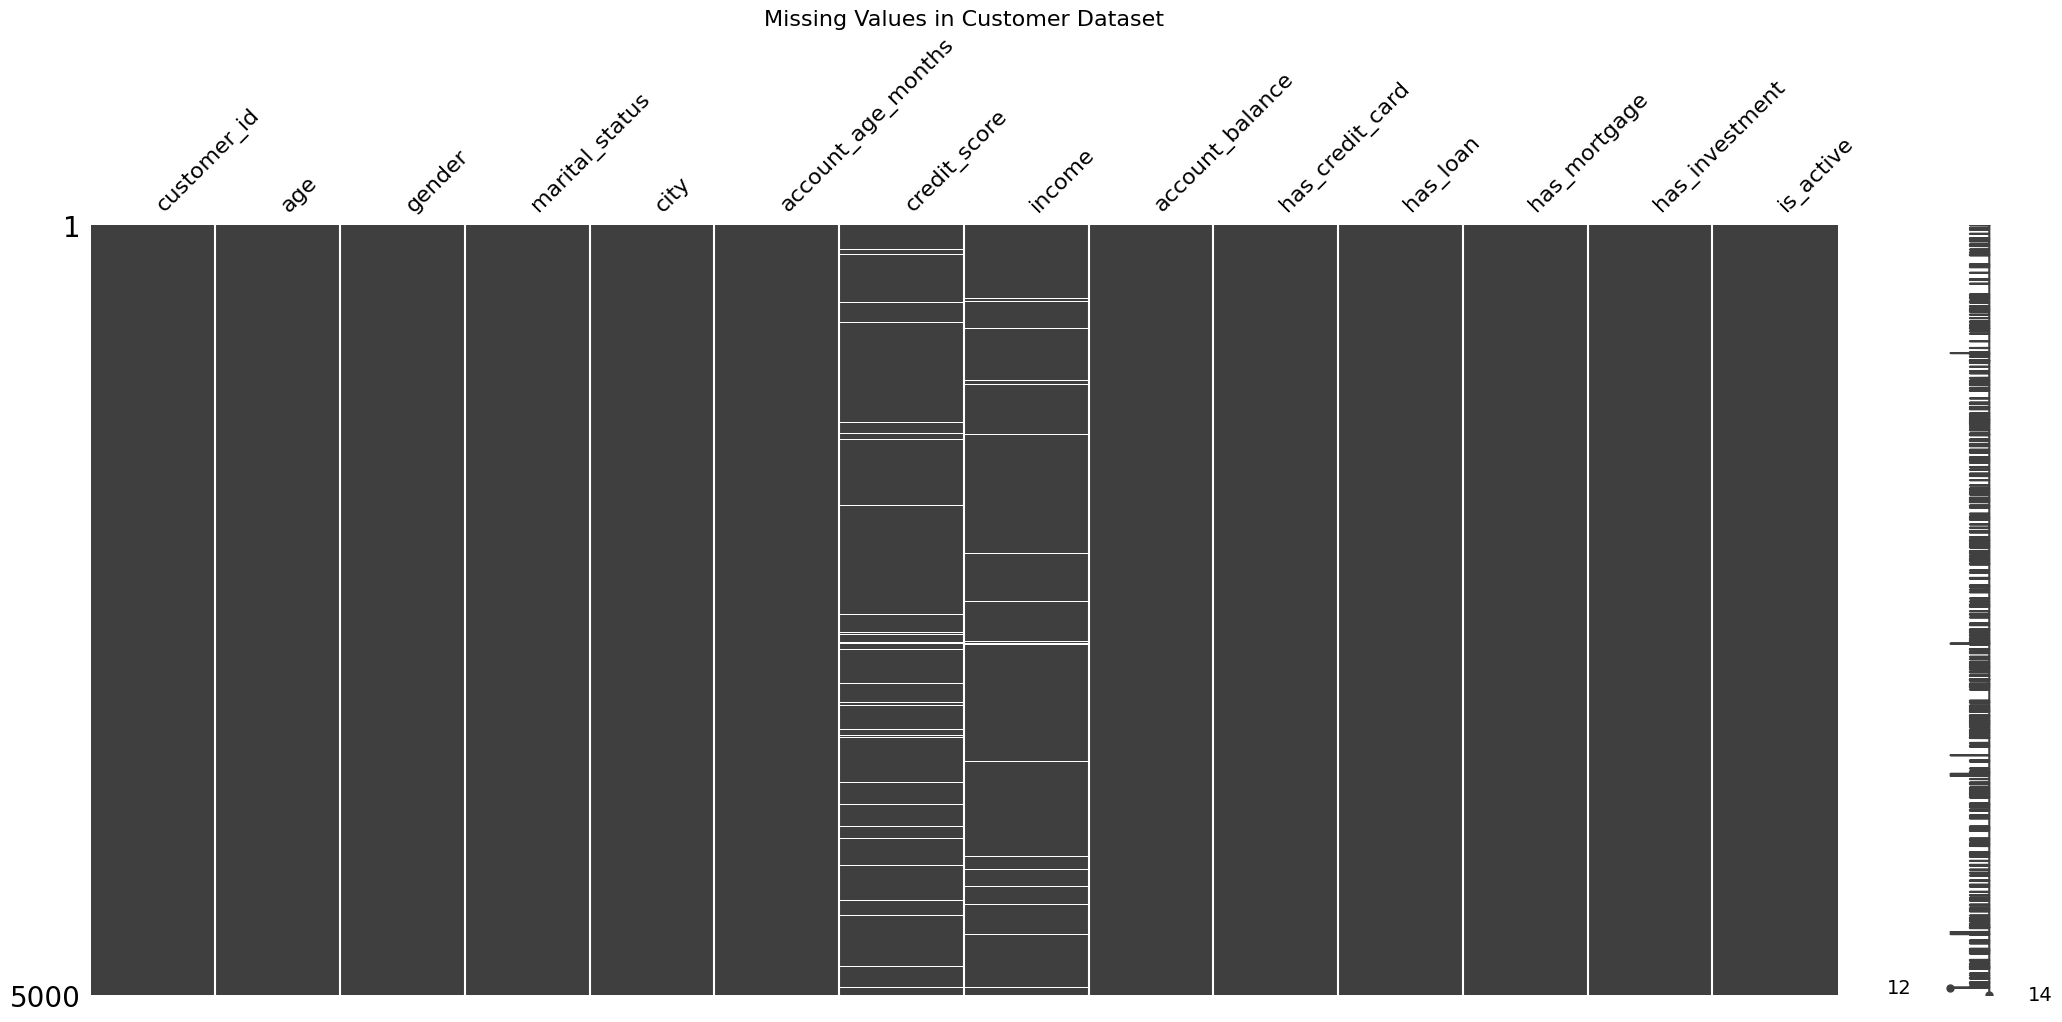

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaction_id     100000 non-null  int64         
 1   customer_id        100000 non-null  int64         
 2   transaction_date   100000 non-null  datetime64[ns]
 3   amount             100000 non-null  int64         
 4   transaction_type   100000 non-null  object        
 5   merchant_category  49915 non-null   object        
 6   status             100000 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 5.3+ MB
Missing values after imputation:
customer_id           0
age                   0
gender                0
marital_status        0
city                  0
account_age_months    0
credit_score          0
income                0
account_balance       0
has_credit_card       0
has_loan              0
has_mortgage         

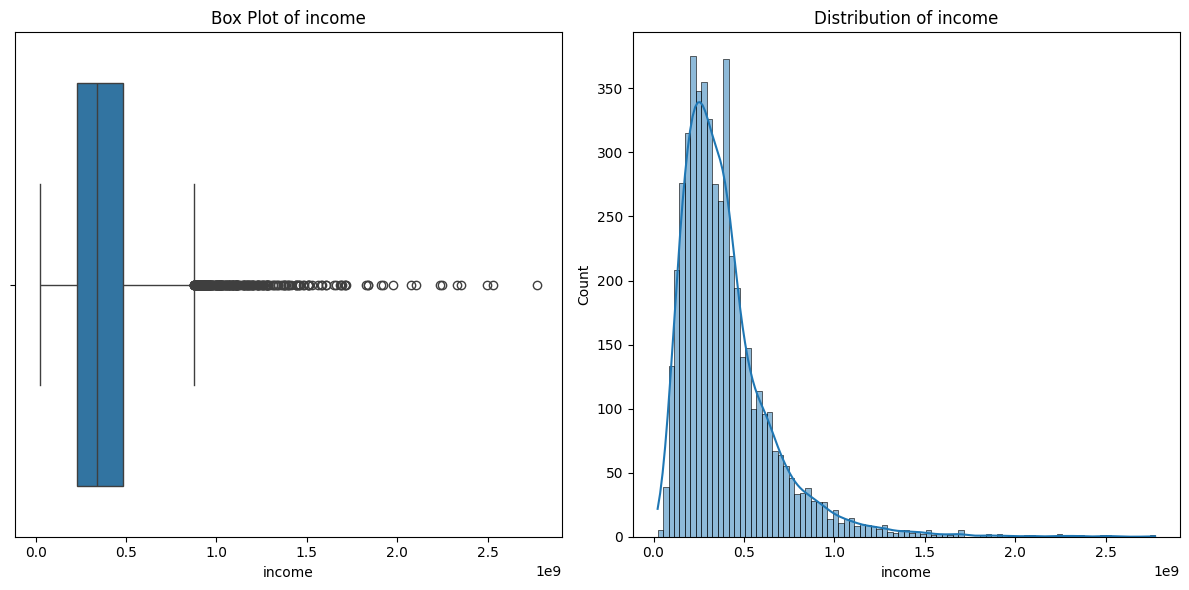

Number of outliers in income: 262
Percentage of outliers: 5.24%


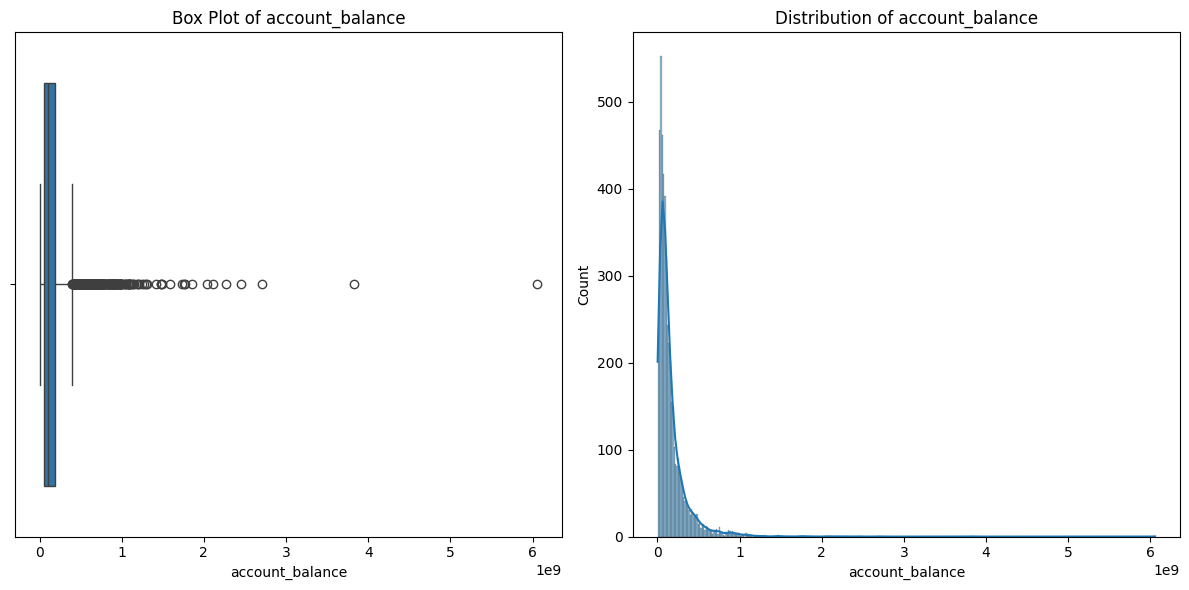

Number of outliers in account_balance: 408
Percentage of outliers: 8.16%


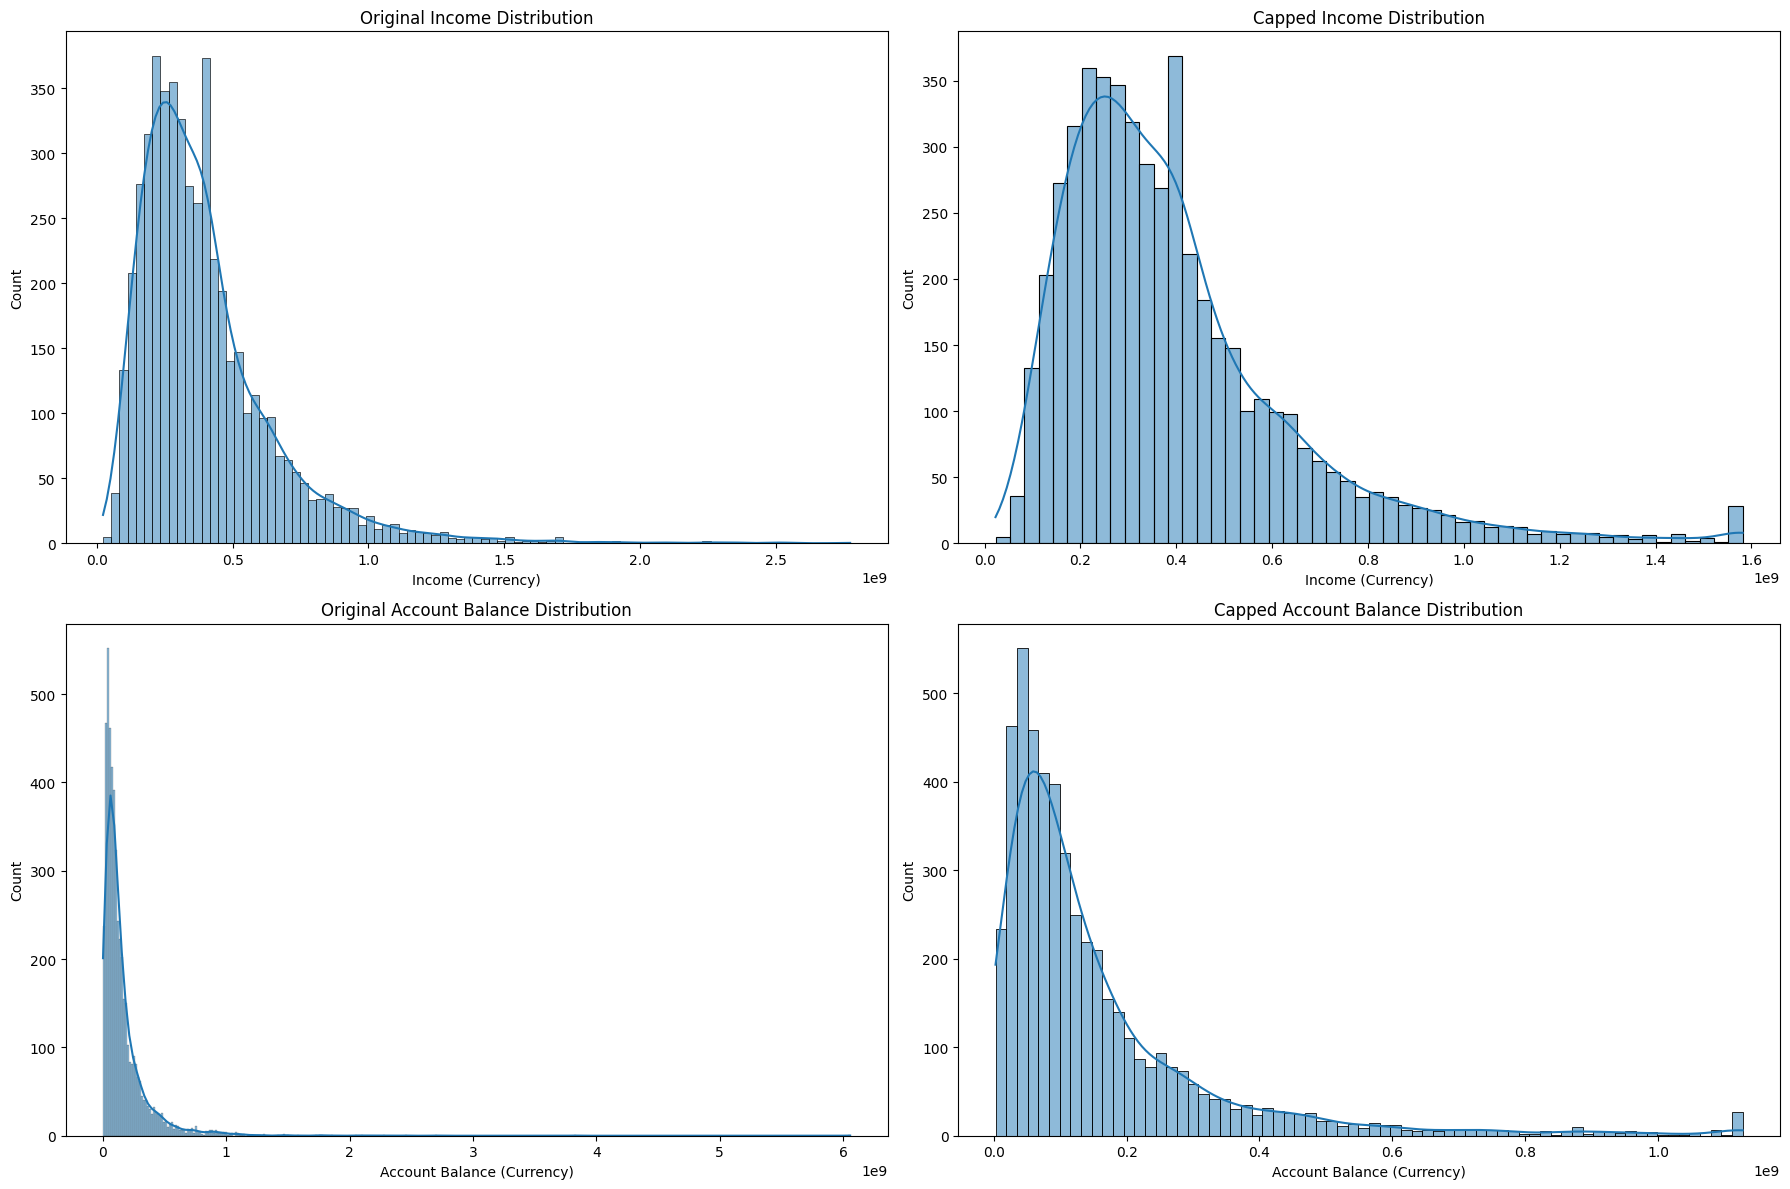

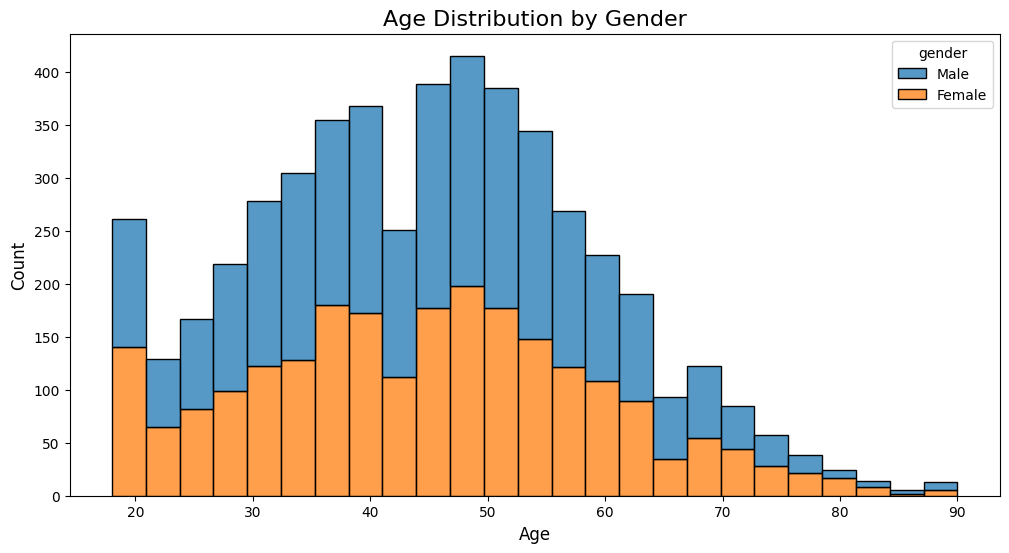

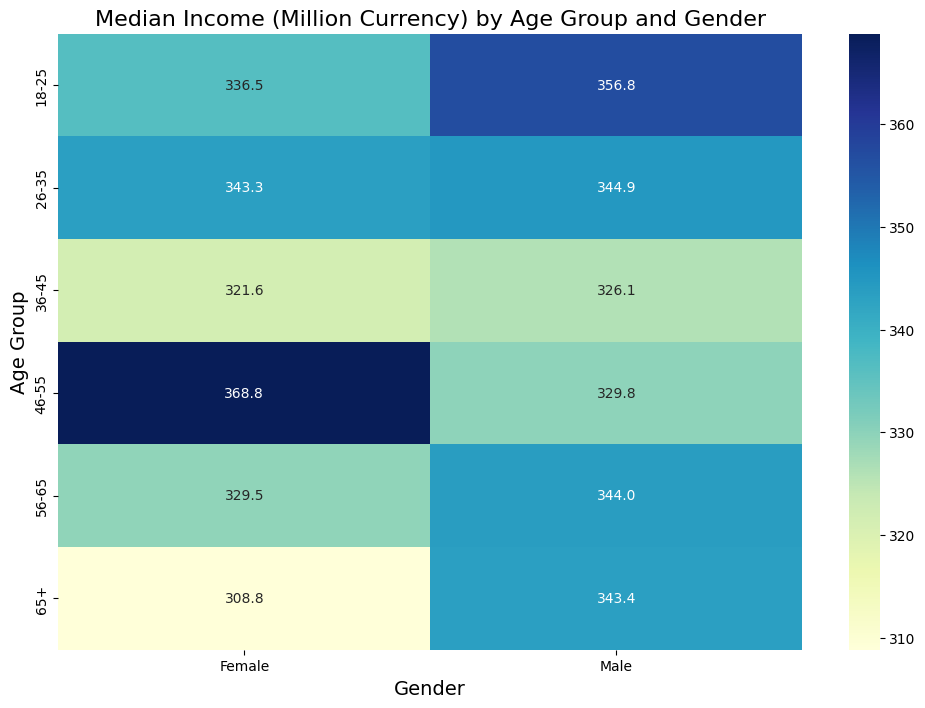

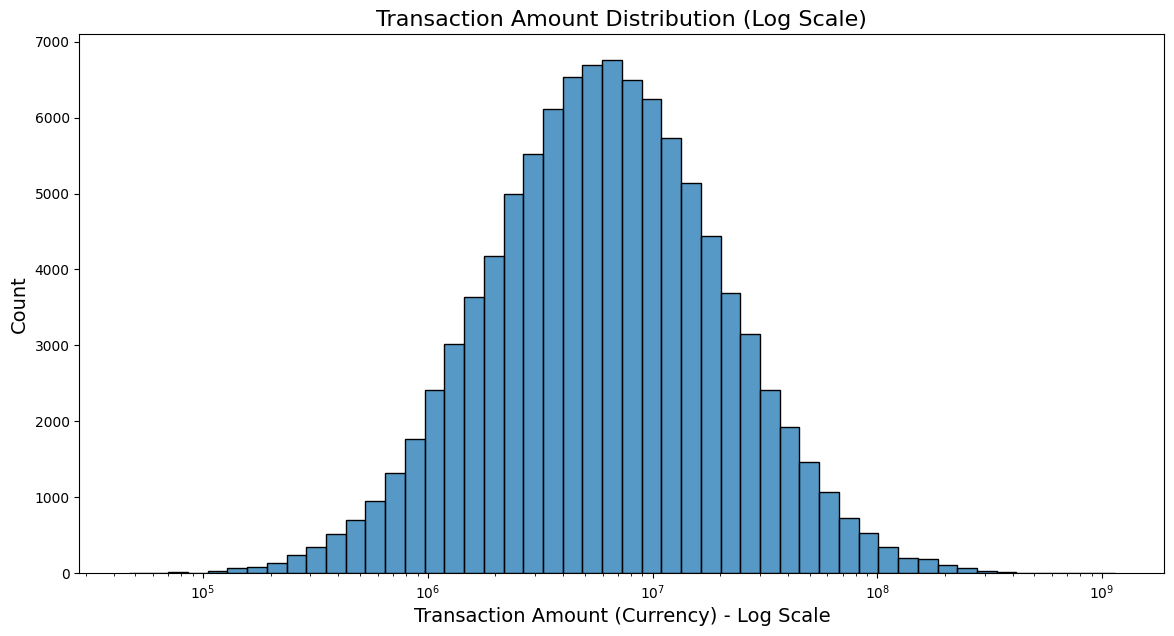

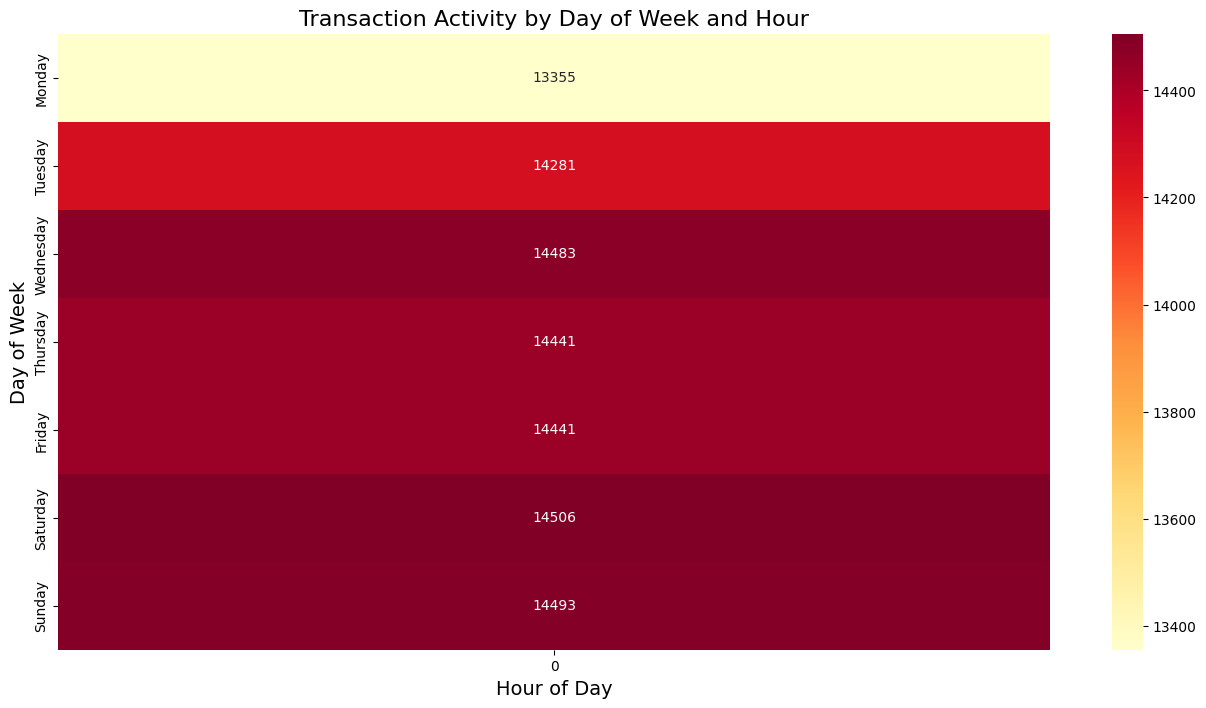

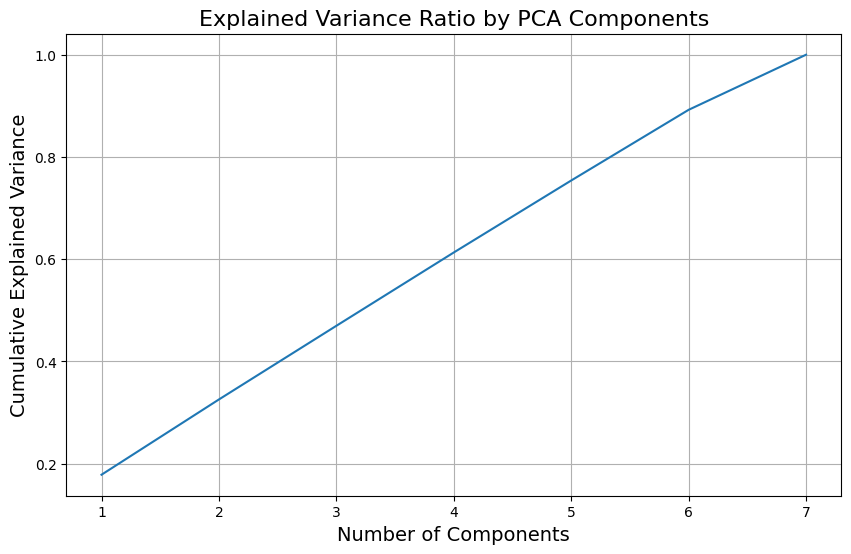

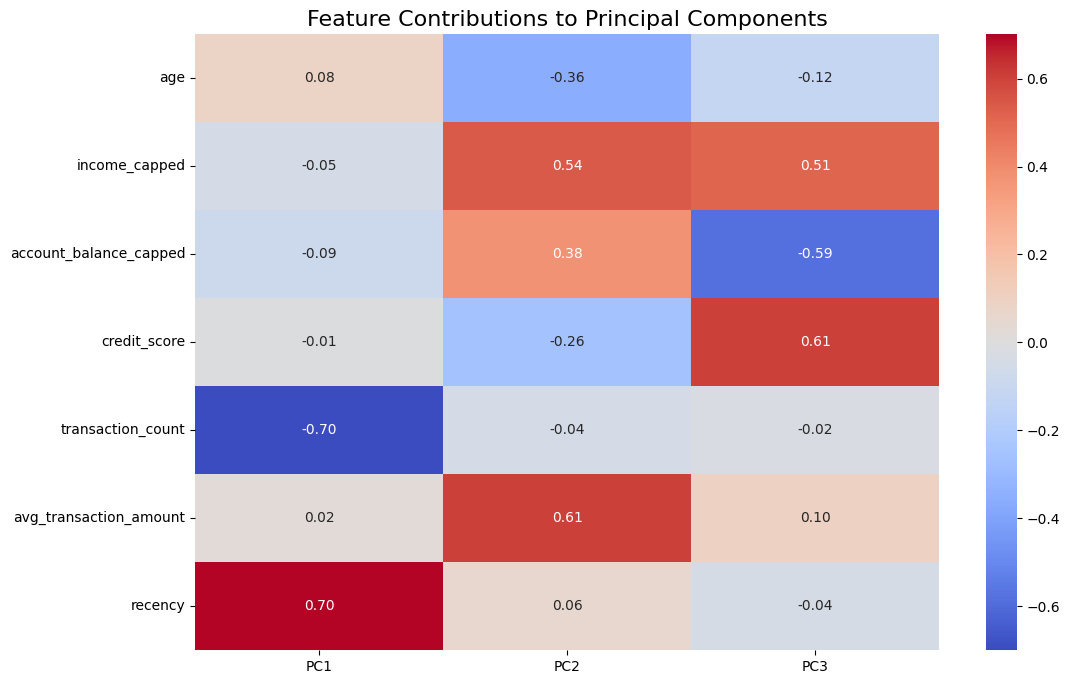

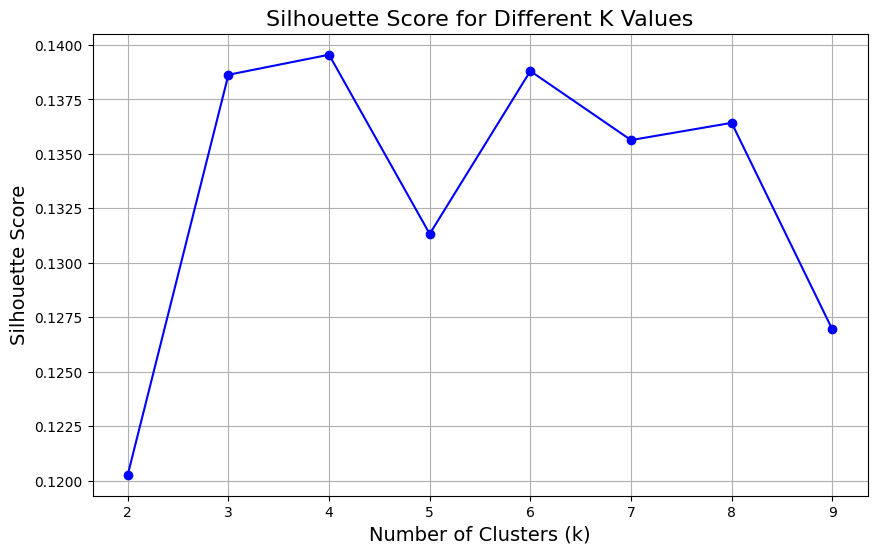

Cluster Profiles:


Detected 1000 anomalous transactions (1.00%)


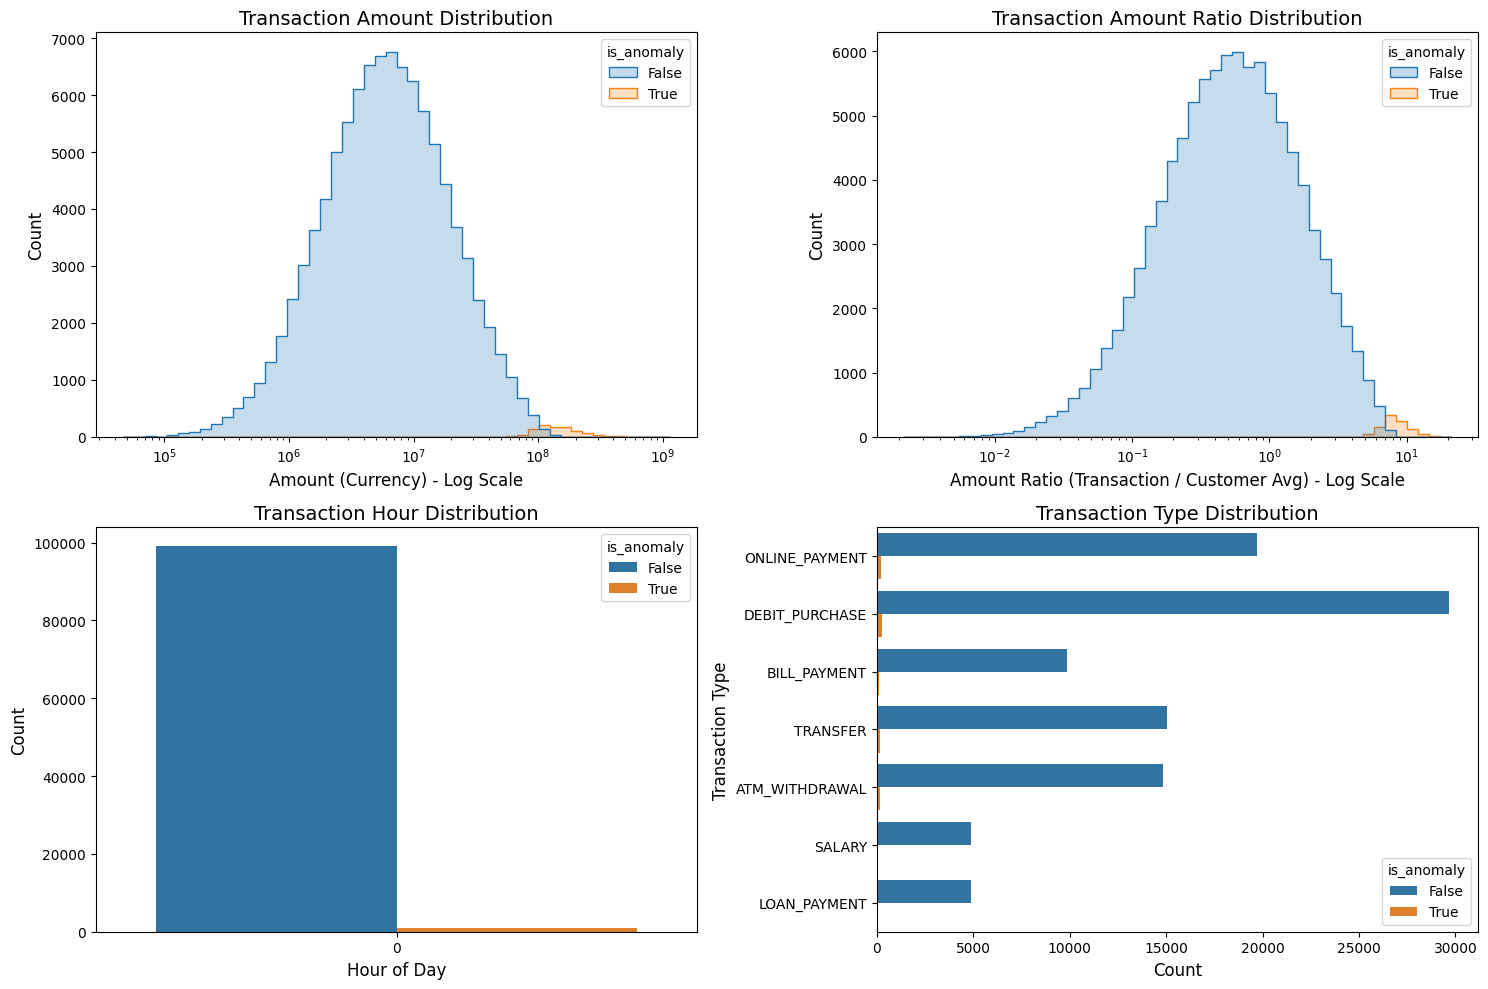

In [ ]:
# Advanced Banking Data Preprocessing and Analysis Project

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import missingno as msno
import datetime as dt
import re
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# %% [markdown]
# # Advanced Banking Data Preprocessing and Analysis Project
#
# In this project, we explore and preprocess a banking dataset. Our goal is to prepare the data for advanced analysis and modeling.
#
# ## Main project stages:
# 1. Data loading and initial exploration
# 2. Data cleaning and preprocessing
# 3. Feature engineering
# 4. Advanced visualization
# 5. Customer clustering analysis
# 6. Fraud detection

# %% [markdown]
# ## 1. Data Loading and Initial Exploration

# %%
# Load the dataset
# We'll simulate a banking dataset with customer and transaction information
# In a real project, you would use actual banking data

# Create customer data
np.random.seed(42)
n_customers = 5000

# Customer demographic data
customer_ids = np.arange(1000000, 1000000 + n_customers)
ages = np.random.normal(45, 15, n_customers).astype(int)
ages = np.clip(ages, 18, 90)  # Ages between 18 and 90

genders = np.random.choice(['Male', 'Female'], size=n_customers, p=[0.52, 0.48])
marital_status = np.random.choice(['Single', 'Married', 'Divorced', 'Widowed'],
                               size=n_customers, p=[0.3, 0.5, 0.15, 0.05])

cities = np.random.choice(
    ['Tehran', 'Mashhad', 'Isfahan', 'Shiraz', 'Tabriz', 'Karaj', 'Ahvaz', 'Qom', 'Kermanshah', 'Rasht'],
    size=n_customers,
    p=[0.25, 0.15, 0.12, 0.1, 0.1, 0.08, 0.07, 0.05, 0.04, 0.04]
)

# Customer financial data
account_age = np.random.randint(1, 240, n_customers)  # Months (up to 20 years)
credit_scores = np.random.normal(650, 100, n_customers)
credit_scores = np.clip(credit_scores, 300, 850)  # Keep as float to allow NaN values

# Income levels with skewed distribution
incomes = np.random.lognormal(mean=3.5, sigma=0.6, size=n_customers) * 10_000_000

# Account balances with skewed distribution
account_balances = np.random.lognormal(mean=3.0, sigma=1.0, size=n_customers) * 5_000_000
account_balances = account_balances.astype(int)

# Create some missing values
random_indices = np.random.choice(range(n_customers), size=int(n_customers * 0.05), replace=False)
credit_scores[random_indices] = np.nan

random_indices = np.random.choice(range(n_customers), size=int(n_customers * 0.03), replace=False)
incomes[random_indices] = np.nan

# Create customer dataframe
customers_df = pd.DataFrame({
    'customer_id': customer_ids,
    'age': ages,
    'gender': genders,
    'marital_status': marital_status,
    'city': cities,
    'account_age_months': account_age,
    'credit_score': credit_scores,
    'income': incomes,
    'account_balance': account_balances
})

# Add some product ownership (binary flags)
customers_df['has_credit_card'] = np.random.choice([0, 1], size=n_customers, p=[0.4, 0.6])
customers_df['has_loan'] = np.random.choice([0, 1], size=n_customers, p=[0.7, 0.3])
customers_df['has_mortgage'] = np.random.choice([0, 1], size=n_customers, p=[0.8, 0.2])
customers_df['has_investment'] = np.random.choice([0, 1], size=n_customers, p=[0.75, 0.25])
customers_df['is_active'] = np.random.choice([0, 1], size=n_customers, p=[0.1, 0.9])

# Now, create transaction data for the last 90 days
n_transactions = 100000
transaction_customer_ids = np.random.choice(customer_ids, size=n_transactions)

# Transaction dates within the last 90 days
current_date = pd.to_datetime('2023-12-31')
random_days = np.random.randint(0, 90, size=n_transactions)
transaction_dates = current_date - pd.to_timedelta(random_days, unit='d')

# Transaction amounts with skewed distribution
transaction_amounts = np.random.lognormal(mean=2.5, sigma=1.2, size=n_transactions) * 500_000
transaction_amounts = transaction_amounts.astype(int)

# Transaction types
transaction_types = np.random.choice(
    ['ATM_WITHDRAWAL', 'DEBIT_PURCHASE', 'ONLINE_PAYMENT', 'TRANSFER', 'BILL_PAYMENT', 'SALARY', 'LOAN_PAYMENT'],
    size=n_transactions,
    p=[0.15, 0.3, 0.2, 0.15, 0.1, 0.05, 0.05]
)

# Create merchant categories for purchases
merchant_categories = []
for t_type in transaction_types:
    if t_type == 'DEBIT_PURCHASE' or t_type == 'ONLINE_PAYMENT':
        merchant_categories.append(np.random.choice(
            ['GROCERY', 'RESTAURANT', 'RETAIL', 'TRAVEL', 'ENTERTAINMENT', 'UTILITY', 'HEALTHCARE', 'EDUCATION'],
            p=[0.25, 0.2, 0.15, 0.1, 0.1, 0.1, 0.05, 0.05]
        ))
    else:
        merchant_categories.append(None)

# Transaction success status
transaction_status = np.random.choice(['SUCCESS', 'FAILED', 'PENDING'], size=n_transactions, p=[0.95, 0.03, 0.02])

# Create transaction dataframe
transactions_df = pd.DataFrame({
    'transaction_id': np.arange(1, n_transactions + 1),
    'customer_id': transaction_customer_ids,
    'transaction_date': transaction_dates,
    'amount': transaction_amounts,
    'transaction_type': transaction_types,
    'merchant_category': merchant_categories,
    'status': transaction_status
})

# Print basic information about the datasets
print("Customers Dataset Shape:", customers_df.shape)
print("Transactions Dataset Shape:", transactions_df.shape)

# Display first few rows of each dataset
print("\nCustomers Dataset Sample:")
customers_df.head()

# %%
# Display transactions sample
print("Transactions Dataset Sample:")
transactions_df.head()

# %%
# Basic information about customer dataset
customers_df.info()

# %%
# Summary statistics for customer dataset
customers_df.describe().T

# %%
# Check missing values in customer dataset
print("Missing values in customer dataset:")
missing_values = customers_df.isnull().sum()
missing_percentage = (missing_values / len(customers_df)) * 100
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
missing_data[missing_data['Missing Values'] > 0]

# %%
# Visualize missing values
plt.figure(figsize=(12, 6))
msno.matrix(customers_df)
plt.title('Missing Values in Customer Dataset', fontsize=16)
plt.show()

# %%
# Basic information about transaction dataset
transactions_df.info()

# %%
# Summary statistics for transaction amounts
transactions_df['amount'].describe()

# %% [markdown]
# ## 2. Data Cleaning and Preprocessing

# %% [markdown]
# ### 2.1 Handling Missing Values

# %%
# Fill missing credit scores with median
median_credit_score = customers_df['credit_score'].median()
customers_df['credit_score'].fillna(median_credit_score, inplace=True)

# Use KNN imputation for income (more sophisticated approach)
income_columns = ['income']
income_imputer = KNNImputer(n_neighbors=5)
customers_df[income_columns] = income_imputer.fit_transform(customers_df[income_columns])

# Verify missing values have been handled
print("Missing values after imputation:")
print(customers_df.isnull().sum())

# %% [markdown]
# ### 2.2 Outlier Detection and Handling

# %%
# Function to detect and visualize outliers
def detect_outliers(df, column):
    plt.figure(figsize=(12, 6))

    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot of {column}')
    plt.tight_layout()

    # Histogram with KDE
    plt.subplot(1, 2, 2)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()

    plt.show()

    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Number of outliers in {column}: {len(outliers)}")
    print(f"Percentage of outliers: {len(outliers) / len(df) * 100:.2f}%")

    return outliers

# %%
# Detect outliers in income
income_outliers = detect_outliers(customers_df, 'income')

# %%
# Detect outliers in account_balance
balance_outliers = detect_outliers(customers_df, 'account_balance')

# %%
# For demonstration, we'll cap extreme values rather than removing them
# For income - cap at 99.5 percentile
income_cap = customers_df['income'].quantile(0.995)
customers_df['income_capped'] = customers_df['income'].clip(upper=income_cap)

# For account balance - cap at 99.5 percentile
balance_cap = customers_df['account_balance'].quantile(0.995)
customers_df['account_balance_capped'] = customers_df['account_balance'].clip(upper=balance_cap)

# Compare original and capped distributions
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Income - Original
sns.histplot(customers_df['income'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Original Income Distribution')
axes[0, 0].set_xlabel('Income (Currency)')

# Income - Capped
sns.histplot(customers_df['income_capped'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Capped Income Distribution')
axes[0, 1].set_xlabel('Income (Currency)')

# Account Balance - Original
sns.histplot(customers_df['account_balance'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Original Account Balance Distribution')
axes[1, 0].set_xlabel('Account Balance (Currency)')

# Account Balance - Capped
sns.histplot(customers_df['account_balance_capped'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Capped Account Balance Distribution')
axes[1, 1].set_xlabel('Account Balance (Currency)')

plt.tight_layout()
plt.show()

# %%
# Use robust scaler which is less sensitive to outliers
numeric_cols = ['age', 'account_age_months', 'credit_score', 'income_capped', 'account_balance_capped']
scaler = RobustScaler()
scaled_data = scaler.fit_transform(customers_df[numeric_cols])

# Create new column names for the scaled features
scaled_cols = [f'{col}_scaled' for col in numeric_cols]

# Add scaled features as new columns
customers_df[scaled_cols] = scaled_data

# %% [markdown]
# ### 2.3 Encoding Categorical Variables

# %%
# One-hot encode categorical variables
categorical_cols = ['gender', 'marital_status', 'city']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = encoder.fit_transform(customers_df[categorical_cols])

# Convert to DataFrame with proper column names
encoded_df = pd.DataFrame(
    encoded_cats,
    columns=encoder.get_feature_names_out(categorical_cols),
    index=customers_df.index
)

# Join with original DataFrame
customers_processed = pd.concat([customers_df, encoded_df], axis=1)

# Display the first few rows of processed data
customers_processed.head()

# %% [markdown]
# ## 3. Feature Engineering

# %%
# Create customer segmentation features

# Create age groups
customers_processed['age_group'] = pd.cut(
    customers_processed['age'],
    bins=[17, 25, 35, 45, 55, 65, 100],
    labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
)

# Create income groups (using original income)
customers_processed['income_group'] = pd.qcut(
    customers_processed['income'],
    q=5,
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

# Calculate product ownership score (how many products they have)
product_columns = ['has_credit_card', 'has_loan', 'has_mortgage', 'has_investment']
customers_processed['product_count'] = customers_processed[product_columns].sum(axis=1)

# %%
# Process transaction data
# Add day of week and hour of day
transactions_df['transaction_day'] = transactions_df['transaction_date'].dt.day_name()
transactions_df['transaction_hour'] = transactions_df['transaction_date'].dt.hour

# Add month and day
transactions_df['transaction_month'] = transactions_df['transaction_date'].dt.month
transactions_df['transaction_day_of_month'] = transactions_df['transaction_date'].dt.day

# %% [markdown]
# ### 3.1 Aggregating Transaction Data

# %%
# Aggregate transaction data by customer
transaction_features = transactions_df.groupby('customer_id').agg(
    transaction_count=('transaction_id', 'count'),
    total_transaction_amount=('amount', 'sum'),
    avg_transaction_amount=('amount', 'mean'),
    max_transaction_amount=('amount', 'max'),
    min_transaction_amount=('amount', 'min'),
    std_transaction_amount=('amount', 'std')
).reset_index()

# Fill NaN values in std column (customers with only one transaction)
transaction_features['std_transaction_amount'].fillna(0, inplace=True)

# Add percentage of successful transactions
success_rate = transactions_df.groupby('customer_id')['status'].apply(
    lambda x: (x == 'SUCCESS').mean()
).reset_index()
success_rate.columns = ['customer_id', 'success_rate']

transaction_features = transaction_features.merge(success_rate, on='customer_id')

# Count transaction types by customer
transaction_types_pivot = pd.crosstab(
    transactions_df['customer_id'],
    transactions_df['transaction_type']
)

# Calculate percentage of each transaction type
transaction_types_percentage = transaction_types_pivot.div(transaction_types_pivot.sum(axis=1), axis=0)
transaction_types_percentage.columns = [f'pct_{col.lower()}' for col in transaction_types_percentage.columns]

# Reset index to merge with other features
transaction_types_percentage.reset_index(inplace=True)

# Merge all transaction features
transaction_features = transaction_features.merge(transaction_types_percentage, on='customer_id')

# %%
# Merge customer and transaction features
customer_full = customers_processed.merge(transaction_features, on='customer_id', how='left')

# Fill NaN values for customers with no transactions
transaction_feature_cols = transaction_features.columns.drop('customer_id')
customer_full[transaction_feature_cols] = customer_full[transaction_feature_cols].fillna(0)

# Display the combined dataset
customer_full.head()

# %%
# Calculate Recency, Frequency, Monetary (RFM) metrics
# We'll use transaction data to calculate these customer-level metrics

# Recency: days since last transaction
latest_date = transactions_df['transaction_date'].max()
last_transaction_date = transactions_df.groupby('customer_id')['transaction_date'].max().reset_index()
last_transaction_date['recency'] = (latest_date - last_transaction_date['transaction_date']).dt.days

# Merge recency with customer data
customer_full = customer_full.merge(last_transaction_date[['customer_id', 'recency']], on='customer_id', how='left')
customer_full['recency'].fillna(90, inplace=True)  # Assume max recency (90 days) for customers with no transactions

# Create RFM score
# For Recency - lower is better, so use rank (smaller values get higher scores)
customer_full['R_score'] = pd.qcut(customer_full['recency'].rank(method='first'),
                                  q=5,
                                  labels=[5, 4, 3, 2, 1])

# For Frequency - higher is better
customer_full['F_score'] = pd.qcut(customer_full['transaction_count'].rank(method='first'),
                                  q=5,
                                  labels=[1, 2, 3, 4, 5])

# For Monetary - higher is better
customer_full['M_score'] = pd.qcut(customer_full['total_transaction_amount'].rank(method='first'),
                                  q=5,
                                  labels=[1, 2, 3, 4, 5])

# Convert to integer for calculation
customer_full['R_score'] = customer_full['R_score'].astype(int)
customer_full['F_score'] = customer_full['F_score'].astype(int)
customer_full['M_score'] = customer_full['M_score'].astype(int)

# Calculate overall RFM score
customer_full['RFM_score'] = customer_full['R_score'] + customer_full['F_score'] + customer_full['M_score']

# Create RFM segment
def rfm_segment(df):
    if df['RFM_score'] >= 13:
        return 'Champions'
    elif df['RFM_score'] >= 10:
        return 'Loyal Customers'
    elif df['RFM_score'] >= 7:
        return 'Potential Loyalists'
    elif df['RFM_score'] >= 5:
        return 'At Risk Customers'
    else:
        return 'Needs Attention'

customer_full['RFM_segment'] = customer_full.apply(rfm_segment, axis=1)

# %% [markdown]
# ## 4. Advanced Visualization

# %% [markdown]
# ### 4.1 Demographic Visualization

# %%
# Age distribution by gender
plt.figure(figsize=(12, 6))
sns.histplot(data=customer_full, x='age', hue='gender', multiple='stack', bins=25)
plt.title('Age Distribution by Gender', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# %%
# Interactive plotly visualization for city distribution
city_counts = customer_full['city'].value_counts().reset_index()
city_counts.columns = ['City', 'Count']

fig = px.bar(city_counts, x='City', y='Count',
             title='Customer Distribution by City',
             labels={'Count': 'Number of Customers', 'City': 'City'},
             color='Count',
             color_continuous_scale='Viridis')

fig.update_layout(
    title_font_size=20,
    xaxis_title_font_size=16,
    yaxis_title_font_size=16,
    template='plotly_white'
)

fig.show()

# %%
# Product ownership by marital status
product_cols = ['has_credit_card', 'has_loan', 'has_mortgage', 'has_investment']
product_ownership = customer_full.groupby('marital_status')[product_cols].mean().reset_index()

# Melt the dataframe for easier plotting
product_ownership_melted = pd.melt(
    product_ownership,
    id_vars=['marital_status'],
    value_vars=product_cols,
    var_name='Product',
    value_name='Ownership Rate'
)

# Clean product names for display
product_ownership_melted['Product'] = product_ownership_melted['Product'].str.replace('has_', '')
product_ownership_melted['Product'] = product_ownership_melted['Product'].str.capitalize()

# Create interactive grouped bar chart
fig = px.bar(
    product_ownership_melted,
    x='marital_status',
    y='Ownership Rate',
    color='Product',
    barmode='group',
    title='Product Ownership by Marital Status',
    labels={'marital_status': 'Marital Status', 'Ownership Rate': 'Ownership Rate (%)'},
)

fig.update_layout(
    title_font_size=20,
    xaxis_title_font_size=16,
    yaxis_title_font_size=16,
    legend_title_font_size=14,
    template='plotly_white',
    yaxis=dict(tickformat='.0%')
)

fig.show()

# %%
# Create an income distribution heatmap by age group and gender
income_heatmap = customer_full.pivot_table(
    values='income_capped',
    index='age_group',
    columns='gender',
    aggfunc='median'
) / 1_000_000  # Convert to millions for readability

plt.figure(figsize=(12, 8))
sns.heatmap(income_heatmap, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Median Income (Million Currency) by Age Group and Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Age Group', fontsize=14)
plt.show()

# %% [markdown]
# ### 4.2 Transaction Behavior Visualization

# %%
# Transaction amount distribution
plt.figure(figsize=(14, 7))
sns.histplot(data=transactions_df, x='amount', log_scale=True, bins=50)
plt.title('Transaction Amount Distribution (Log Scale)', fontsize=16)
plt.xlabel('Transaction Amount (Currency) - Log Scale', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

# %%
# Transaction types distribution
transaction_type_counts = transactions_df['transaction_type'].value_counts().reset_index()
transaction_type_counts.columns = ['Transaction Type', 'Count']

# Create pie chart
fig = px.pie(
    transaction_type_counts,
    values='Count',
    names='Transaction Type',
    title='Distribution of Transaction Types',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_layout(
    title_font_size=20,
    legend_title_font_size=14,
    template='plotly_white'
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# %%
# Transaction activity by day of week and hour
# Create a heatmap of transaction counts by day and hour
day_hour_counts = pd.crosstab(
    transactions_df['transaction_day'],
    transactions_df['transaction_hour']
)

# Reorder days of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_hour_counts = day_hour_counts.reindex(day_order)

plt.figure(figsize=(16, 8))
sns.heatmap(day_hour_counts, cmap='YlOrRd', annot=True, fmt='d')
plt.title('Transaction Activity by Day of Week and Hour', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Day of Week', fontsize=14)
plt.show()

# %%
# Interactive time series of daily transaction volume and amount
daily_transactions = transactions_df.groupby(transactions_df['transaction_date'].dt.date).agg(
    transaction_count=('transaction_id', 'count'),
    transaction_volume=('amount', 'sum')
).reset_index()

# Create a dual-axis line plot
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(
        x=daily_transactions['transaction_date'],
        y=daily_transactions['transaction_count'],
        name="Number of Transactions",
        line=dict(color='royalblue')
    ),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(
        x=daily_transactions['transaction_date'],
        y=daily_transactions['transaction_volume'] / 1_000_000_000,  # Convert to billions
        name="Transaction Volume (Billion Currency)",
        line=dict(color='firebrick')
    ),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title="Daily Transaction Count and Volume",
    template='plotly_white',
    hovermode='x unified',
    title_font_size=20,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Number of Transactions", secondary_y=False)
fig.update_yaxes(title_text="Transaction Volume (Billion Currency)", secondary_y=True)

fig.show()

# %% [markdown]
# ### 4.3 Customer Segment Visualization

# %%
# Visualize RFM segments
rfm_segment_counts = customer_full['RFM_segment'].value_counts().reset_index()
rfm_segment_counts.columns = ['Segment', 'Count']

# Create a sunburst chart combining RFM segments and income groups
rfm_income_counts = customer_full.groupby(['RFM_segment', 'income_group']).size().reset_index()
rfm_income_counts.columns = ['RFM_segment', 'Income_Group', 'Count']

fig = px.sunburst(
    rfm_income_counts,
    path=['RFM_segment', 'Income_Group'],
    values='Count',
    title='Customer Segments by RFM and Income Group',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_layout(
    title_font_size=20,
    template='plotly_white'
)

fig.show()

# %%
# Compare transaction behavior across RFM segments
rfm_transaction_behavior = customer_full.groupby('RFM_segment').agg(
    avg_transaction_count=('transaction_count', 'mean'),
    avg_transaction_amount=('avg_transaction_amount', 'mean'),
    avg_total_spent=('total_transaction_amount', 'mean'),
    avg_account_balance=('account_balance_capped', 'mean')
).reset_index()

# Melt for easier visualization
rfm_transaction_melted = pd.melt(
    rfm_transaction_behavior,
    id_vars=['RFM_segment'],
    value_vars=['avg_transaction_count', 'avg_transaction_amount', 'avg_total_spent', 'avg_account_balance'],
    var_name='Metric',
    value_name='Value'
)

# Clean metric names
rfm_transaction_melted['Metric'] = rfm_transaction_melted['Metric'].replace({
    'avg_transaction_count': 'Average Transaction Count',
    'avg_transaction_amount': 'Average Transaction Amount',
    'avg_total_spent': 'Average Total Spent',
    'avg_account_balance': 'Average Account Balance'
})

# Create grouped bar chart
fig = px.bar(
    rfm_transaction_melted,
    x='RFM_segment',
    y='Value',
    color='Metric',
    barmode='group',
    title='Transaction Behavior by RFM Segment',
    labels={'RFM_segment': 'RFM Segment', 'Value': 'Value'},
    color_discrete_sequence=px.colors.qualitative.G10
)

fig.update_layout(
    title_font_size=20,
    legend_title_font_size=14,
    template='plotly_white'
)

fig.show()

# %% [markdown]
# ## 5. Customer Clustering Analysis

# %%
# Select features for clustering
cluster_features = [
    'age', 'income_capped', 'account_balance_capped', 'credit_score',
    'transaction_count', 'avg_transaction_amount', 'recency'
]

# Scale the features
X = customer_full[cluster_features].copy()
X_scaled = StandardScaler().fit_transform(X)

# %% [markdown]
# ### 5.1 PCA for Dimensionality Reduction

# %%
# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(X_scaled)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained Variance Ratio by PCA Components', fontsize=16)
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.grid(True)
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

# %%
# Select optimal number of components (e.g., 3 components explaining >80% variance)
n_components = 3
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(X_scaled)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(
    data=pca_result,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

# Feature importance in each principal component
component_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=cluster_features
)

plt.figure(figsize=(12, 8))
sns.heatmap(component_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Contributions to Principal Components', fontsize=16)
plt.show()

# %% [markdown]
# ### 5.2 K-means Clustering

# %%
# Determine optimal number of clusters using silhouette score
sil_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, sil_scores, 'bo-')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Score for Different K Values', fontsize=16)
plt.grid(True)
plt.show()

# %%
# Apply K-means with optimal number of clusters (let's say k=4 based on silhouette score)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
customer_full['cluster'] = kmeans.fit_predict(X_scaled)

# %%
# Visualize clusters in PCA space
pca_df['cluster'] = customer_full['cluster']

# Create 3D scatter plot
fig = px.scatter_3d(
    pca_df, x='PC1', y='PC2', z='PC3',
    color='cluster',
    labels={'cluster': 'Cluster'},
    title='Customer Clusters in PCA Space',
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_layout(
    title_font_size=20,
    template='plotly_white'
)

fig.show()

# %%
# Analyze cluster profiles
cluster_profiles = customer_full.groupby('cluster').agg({
    'age': 'mean',
    'income_capped': 'mean',
    'account_balance_capped': 'mean',
    'credit_score': 'mean',
    'transaction_count': 'mean',
    'avg_transaction_amount': 'mean',
    'recency': 'mean',
    'RFM_score': 'mean'
}).reset_index()

# Format for better readability
for col in ['income_capped', 'account_balance_capped', 'avg_transaction_amount']:
    cluster_profiles[col] = cluster_profiles[col].apply(lambda x: f"{x:,.0f}")

# Display cluster profiles
print("Cluster Profiles:")
cluster_profiles

# %%
# Create a radar chart to visualize cluster profiles
# First, normalize the features for radar chart
cluster_radar = customer_full.groupby('cluster').agg({
    'age': 'mean',
    'income_capped': 'mean',
    'account_balance_capped': 'mean',
    'credit_score': 'mean',
    'transaction_count': 'mean',
    'avg_transaction_amount': 'mean',
    'recency': 'mean'
})

# Normalize each column to 0-1 scale
for col in cluster_radar.columns:
    cluster_radar[col] = (cluster_radar[col] - cluster_radar[col].min()) / (cluster_radar[col].max() - cluster_radar[col].min())

# Prepare data for radar chart
categories = cluster_radar.columns.tolist()
fig = go.Figure()

for i in range(len(cluster_radar)):
    fig.add_trace(go.Scatterpolar(
        r=cluster_radar.iloc[i].values.tolist() + [cluster_radar.iloc[i].values.tolist()[0]],  # Close the loop
        theta=categories + [categories[0]],  # Close the loop
        fill='toself',
        name=f'Cluster {i}'
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    title="Cluster Profiles Comparison",
    title_font_size=20,
    showlegend=True,
    template='plotly_white'
)

fig.show()

# %% [markdown]
# ## 6. Fraud Detection

# %%
# We'll use Isolation Forest for anomaly detection in transactions
# Prepare transaction features for anomaly detection

# Select relevant features
fraud_features = [
    'amount',
    'transaction_hour',
    'transaction_day_of_month'
]

# Create additional features
transactions_processed = transactions_df.copy()

# Get customer average transaction amount
customer_avg_amount = transactions_df.groupby('customer_id')['amount'].mean().reset_index()
customer_avg_amount.columns = ['customer_id', 'customer_avg_amount']
transactions_processed = transactions_processed.merge(customer_avg_amount, on='customer_id')

# Calculate amount ratio (transaction amount / customer average)
transactions_processed['amount_ratio'] = transactions_processed['amount'] / transactions_processed['customer_avg_amount']
transactions_processed['amount_ratio'].fillna(1, inplace=True)  # For customers with only one transaction

# Get customer transaction frequency (transactions per day)
customer_tx_frequency = transactions_df.groupby('customer_id').size() / 90  # 90 days period
customer_tx_frequency = customer_tx_frequency.reset_index()
customer_tx_frequency.columns = ['customer_id', 'tx_frequency']
transactions_processed = transactions_processed.merge(customer_tx_frequency, on='customer_id')

# Add these new features to fraud detection features
fraud_features.extend(['amount_ratio', 'tx_frequency'])

# Scale the features
X_fraud = transactions_processed[fraud_features].copy()
X_fraud_scaled = StandardScaler().fit_transform(X_fraud)

# %%
# Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # Assume 1% anomalies
transactions_processed['anomaly_score'] = iso_forest.fit_predict(X_fraud_scaled)
transactions_processed['is_anomaly'] = transactions_processed['anomaly_score'] == -1  # -1 for anomalies, 1 for normal

# Count anomalies
anomaly_count = transactions_processed['is_anomaly'].sum()
print(f"Detected {anomaly_count} anomalous transactions ({anomaly_count/len(transactions_processed)*100:.2f}%)")

# %%
# Analyze anomalous transactions
anomalous_tx = transactions_processed[transactions_processed['is_anomaly'] == True]

# Compare distributions of normal vs anomalous transactions
plt.figure(figsize=(15, 10))

# Amount distribution
plt.subplot(2, 2, 1)
sns.histplot(data=transactions_processed, x='amount', hue='is_anomaly', log_scale=True, bins=50, element='step')
plt.title('Transaction Amount Distribution', fontsize=14)
plt.xlabel('Amount (Currency) - Log Scale', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Amount ratio distribution
plt.subplot(2, 2, 2)
sns.histplot(data=transactions_processed, x='amount_ratio', hue='is_anomaly', log_scale=True, bins=50, element='step')
plt.title('Transaction Amount Ratio Distribution', fontsize=14)
plt.xlabel('Amount Ratio (Transaction / Customer Avg) - Log Scale', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Transaction hour distribution
plt.subplot(2, 2, 3)
sns.countplot(data=transactions_processed, x='transaction_hour', hue='is_anomaly')
plt.title('Transaction Hour Distribution', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Transaction type distribution
plt.subplot(2, 2, 4)
sns.countplot(data=transactions_processed, y='transaction_type', hue='is_anomaly')
plt.title('Transaction Type Distribution', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Transaction Type', fontsize=12)

plt.tight_layout()
plt.show()

# %%
# Create a scatter plot of anomalies
fig = px.scatter(
    transactions_processed,
    x='amount',
    y='amount_ratio',
    color='is_anomaly',
    log_x=True,
    log_y=True,
    hover_data=['customer_id', 'transaction_type', 'transaction_date'],
    labels={'amount': 'Transaction Amount (Currency)', 'amount_ratio': 'Amount Ratio'},
    title='Anomalous Transactions Detection',
    color_discrete_map={True: 'red', False: 'blue'}
)

fig.update_layout(
    title_font_size=20,
    template='plotly_white',
    xaxis_title_font_size=14,
    yaxis_title_font_size=14
)

fig.show()

# %% [markdown]
# ## 7. Summary and Conclusion

# %% [markdown]
# In this project, we performed a comprehensive analysis of banking data and reached the following conclusions:
#
# 1. **Data Preprocessing and Cleaning**: We filled missing data using advanced methods, identified and managed outliers, and encoded categorical variables.
#
# 2. **Feature Engineering**: We created new features such as age and income groups and aggregated transaction information. We also calculated an RFM score for each customer.
#
# 3. **Advanced Visualization**: We created various visualizations to better understand the data, including demographic analysis, transaction behavior, and customer segments.
#
# 4. **Customer Clustering**: Using K-means, we categorized customers into four clusters and analyzed the profile of each cluster.
#
# 5. **Fraud Detection**: Using the Isolation Forest algorithm, we identified suspicious transactions and analyzed their characteristics.
#
# ### Practical Applications:
#
# - **Targeted Marketing**: Using RFM segments and customer clustering, targeted marketing campaigns can be designed.
# - **Risk Management**: Identifying suspicious transactions can help prevent fraud.
# - **Product Development**: By understanding customer behavior, new products can be designed to meet the needs of different clusters.
# - **Improving Customer Experience**: By understanding transaction patterns and customer preferences, banking services can be improved.
#
# ### Next Steps:
#
# - Create predictive models to identify customers who are likely to churn.
# - Develop a recommendation system to suggest suitable products to each customer segment.
# - Improve the suspicious transaction detection algorithm with more data and more complex features.
#
# This project provides a framework for banking data analysis that can be expanded with real data and used for various business applications.